In [59]:
pip install opendatasets --upgrade --quiet

In [63]:
import opendatasets as od
download_url = 'https://www.kaggle.com/datasets/ander289386/cars-germany'
od.download(download_url)

Skipping, found downloaded files in "./cars-germany" (use force=True to force download)


In [65]:
file_path = './cars-germany/autoscout24-germany-dataset.csv'

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [66]:
cars = pd.read_csv(file_path)
cars.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [ ]:
# Let's find out a bit more about the variables in the dataframe:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


There are 46405 rows in the dataframe, and 9 variables in total. Of these, 4 are numerical variables (of dtype "int64" or "float64") and 5 are categorical (of dtype "object"). The 'model', 'gear' and 'hp' variables have a few null values, and we shall take care of these by dropping the corresponding rows (we don't expect this to have a big impact since the number of null values is relatively small).

In [ ]:
# Numerical columns
num_cols = list(cars._get_numeric_data().columns)
print(num_cols)

['mileage', 'price', 'hp', 'year']


In [ ]:
# Categorical columns
cat_cols = set(cars.columns) - set(num_cols)
print(cat_cols)

{'make', 'fuel', 'offerType', 'gear', 'model'}


## 2. Data Cleaning

In this section, we want to start exploring some of the variables in our dataset. Our goal is not to be detailed and thourough: rather, we just want to get a feel of how our data looks like. In other words, we just want to do enough exploration to be able to build a basic regression model.

We shall start our exploratory data analysis by plotting a heat map of the correlations between the numerical variables in our dataset. This is easily achieved by using the heatmap() function in Seaborn, combined with the corr() method to compute the correlation matrix between numerical features as follows:

Right off the bat, we want to transform the 'year' variable to an 'age' variable representing the age of the car as of now:
### 2.1 Basic data cleaning

In [ ]:
# Create a new column: 'age'
cars['age'] = datetime.now().year - cars['year']

# Drop the 'year' column
cars = cars.drop('year', axis=1)

# Show the top five rows of the cars dataset
cars.head()

,mileage,make,model,fuel,gear,offerType,price,hp,age
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,11
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,11
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,11
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,11
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,11


In [ ]:
# Drop the rows with null values
cars = cars.dropna()

# Display the total number of null values in the resulting dataframe
cars.isna().sum()

mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
age          0
dtype: int64

In [ ]:
# It's also a good idea to drop duplicate rows:
cars = cars.drop_duplicates(keep='first')
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43947 entries, 0 to 46399
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    43947 non-null  int64  
 1   make       43947 non-null  object 
 2   model      43947 non-null  object 
 3   fuel       43947 non-null  object 
 4   gear       43947 non-null  object 
 5   offerType  43947 non-null  object 
 6   price      43947 non-null  int64  
 7   hp         43947 non-null  float64
 8   age        43947 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


### 2.2 Removing the makes and models that have few data points in the dataframe
First we want find which car makes and models have the most entries in the dataframe. 

In [ ]:
# Count the values of each distinct make and model in the dataset
make_model_counts = cars[['make','model']].value_counts()

# Transform the resulting Pandas series into a dataframe
make_model_counts = pd.DataFrame(make_model_counts)

# Inspect the result
make_model_counts

0
make       model           
Volkswagen Golf        1450
Opel       Corsa       1393
Ford       Fiesta      1221
Opel       Astra       1141
Ford       Focus        948
...                     ...
Baic       Senova X35     1
           BJ20           1
Nissan     Pathfinder     1
Isuzu      D-Max          1
Maserati   GranCabrio     1

[844 rows x 1 columns]

We notice that there are make and models that have several hundred data rows: for example, there are 1450 data rows corresponding to Volkswagen Golf cars. However, there are also specific models that have only 1 data point in the dataframe (for example: Maserati GranCabrio). We will contend that: in order for us to be able to build a reliable model, we will need to drop all the make & model combinations that have only a few datapoints in the dataset. We will see that by keeping only makes and models that have a substantial number of data points, say more than 100 rows in the dataset, we'll be able to achieve better performance for our model. The reason we are choosing 100 data rows has to do with the fact that the age variable can take 11 different values. Hence, by choosing makes and models that have at least 100 data points, we can hope to have at least a few points per age category, and hope therefore to get an reasonable estimate for the price of cars of various ages. In any case, we want to explore this idea and see where it leads us.

In [ ]:
# Reset the index of the dataframe
make_model_counts.reset_index(inplace=True)

# Change the name of the count column to 'count'
make_model_counts.columns = ['make','model','count']

# Inspect the result
make_model_counts

,make,model,count
0,Volkswagen,Golf,1450
1,Opel,Corsa,1393
2,Ford,Fiesta,1221
3,Opel,Astra,1141
4,Ford,Focus,948
...,...,...,...
839,Baic,Senova X35,1
840,Baic,BJ20,1
841,Nissan,Pathfinder,1
842,Isuzu,D-Max,1


We only want to keep car make and model combos that have at least 100 datapoints in the dataframe.

In [ ]:
make_model_counts = make_model_counts[make_model_counts['count'] >= 100]
make_model_counts

,make,model,count
0,Volkswagen,Golf,1450
1,Opel,Corsa,1393
2,Ford,Fiesta,1221
3,Opel,Astra,1141
4,Ford,Focus,948
...,...,...,...
104,Skoda,Kodiaq,101
105,Volkswagen,Golf Plus,101
106,Mercedes-Benz,Vito,101
107,Dacia,Logan,100


In [ ]:
# How many data points did we keep in the dataframe?
print('Number of cars in the make_model_counts dataframe: ', make_model_counts['count'].sum())

Number of cars in the make_model_counts dataframe:  32153


We now want to find a way to keep only the make and model combinations that appear in the make_model_counts dataframe in the original cars dataframe.

In [ ]:
make_model_counts.loc[:,'make+model'] = make_model_counts.loc[:,'make'] + make_model_counts.loc[:,'model']
make_model_counts['make+model']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


0           VolkswagenGolf
1                OpelCorsa
2               FordFiesta
3                OpelAstra
4                FordFocus
              ...         
104            SkodaKodiaq
105    VolkswagenGolf Plus
106      Mercedes-BenzVito
107             DaciaLogan
108                 Mazda6
Name: make+model, Length: 109, dtype: object

In [ ]:
# Make a new column in the cars dataset that combines the make and model for every row
cars['make_model'] = cars['make'] + cars['model']
cars.head()

,mileage,make,model,fuel,gear,offerType,price,hp,age,make_model
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,11,BMW316
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,11,VolkswagenGolf
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,11,SEATExeo
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,11,RenaultMegane
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,11,Peugeot308


In [ ]:
# Only keep he make and model combinations in the cars dataframe that appear in the make_model_counts dataframe
cars = cars[cars['make_model'].isin(make_model_counts['make+model'])]
cars.head()

,mileage,make,model,fuel,gear,offerType,price,hp,age,make_model
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,11,VolkswagenGolf
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,11,RenaultMegane
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,11,Peugeot308
5,147000,Toyota,Auris,Electric/Gasoline,Automatic,Used,6950,99.0,11,ToyotaAuris
6,91894,Renault,Scenic,Diesel,Manual,Used,6970,131.0,11,RenaultScenic


### 2.3 Numerical variables

#### 2.3.1 The price variable

In [ ]:
# Let's print some basic statistics for he price variable
cars.price.describe()

count    32153.000000
mean     13136.599913
std       9008.675723
min       1100.000000
25%       7190.000000
50%       9999.000000
75%      15770.000000
max      97880.000000
Name: price, dtype: float64

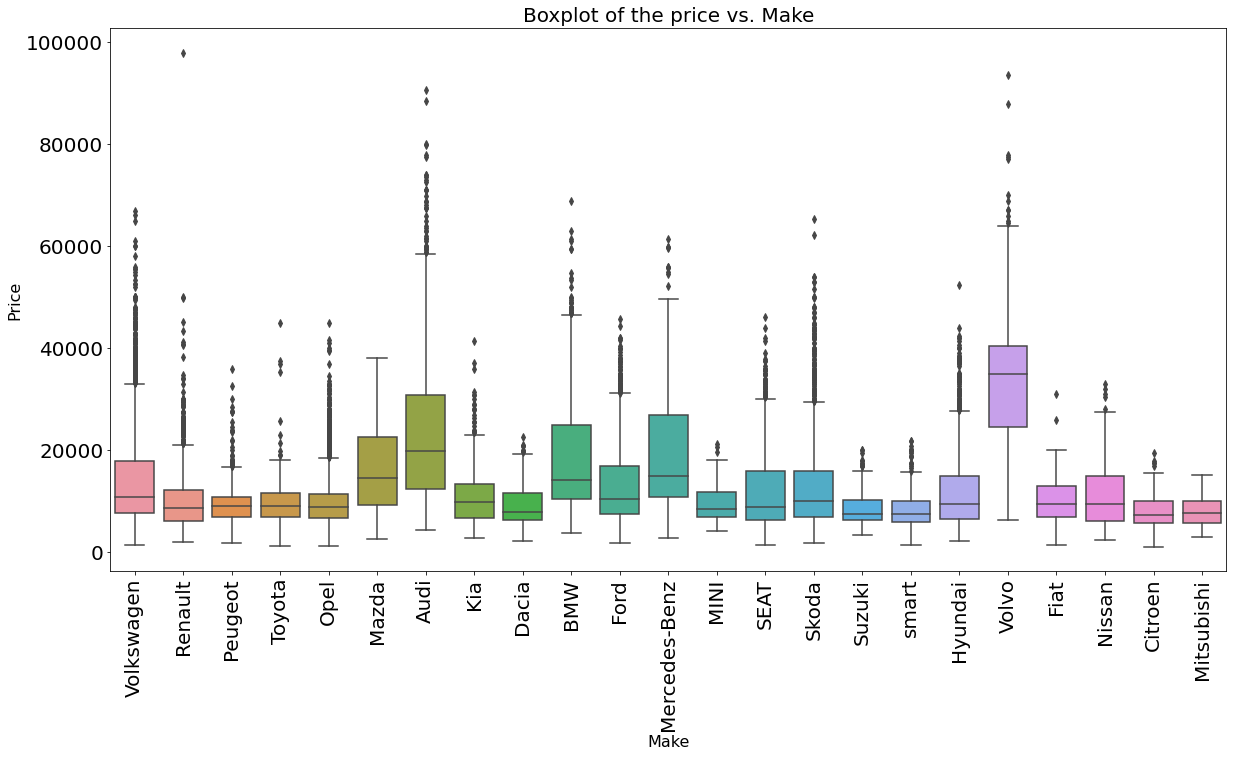

In [ ]:
# Let's plot a boxplot of car price for various makes

plt.figure(figsize=(20,10))
sns.boxplot(x = cars.make, y = cars.price)

plt.xlabel('Make', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Boxplot of the price vs. Make', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

# Rotate the tick labels on the x-axis by 90 degrees
plt.xticks(rotation=90)

plt.show()

We now want to remove the outliers for each car make in the above figure. First, let's make a list of all the car makes in our cars dataframe:

In [ ]:
makes = set(cars.make)
print(makes)

{'Opel', 'SEAT', 'Suzuki', 'Audi', 'Citroen', 'Mazda', 'BMW', 'Toyota', 'Kia', 'Renault', 'Fiat', 'Dacia', 'Volvo', 'Skoda', 'Peugeot', 'Hyundai', 'Mitsubishi', 'Ford', 'Mercedes-Benz', 'Nissan', 'smart', 'Volkswagen', 'MINI'}


In [ ]:
# Create a blank dataframe with the same columns as the cars dataframe
vehicles = pd.DataFrame(columns=cars.columns)

# For each make in the makes list
for make in makes:
    # compute the 75% quantile
    q75 = cars[cars.make == make].price.quantile(0.75)
    
    # Compute the 25% quantile
    q25 = cars[cars.make == make].price.quantile(0.25)
    
    # Find the interquantile range
    iqr = q75 - q25
    
    # Select the rows from cars that have this make and that have a price between
    # q25 - 1.5*iqr and q75 + 1.5*iqr. Store the result in a temporary dataframe: tmp_df
    tmp_df = cars[(cars.make == make) & (cars.price < q75 + 1.5 * iqr) & (cars.price > q25 - 1.5 * iqr)]
    
    # Concatenate tmp_df to the vehicles dataframe at each iteration of the loop
    vehicles = pd.concat([vehicles, tmp_df], ignore_index = True)

In [ ]:
# Inspect the resulting dataframe
vehicles.head()

,mileage,make,model,fuel,gear,offerType,price,hp,age,make_model
0,127500,Opel,Zafira,Gasoline,Manual,Used,6972,116.0,11,OpelZafira
1,59580,Opel,Meriva,Diesel,Automatic,Used,6990,101.0,11,OpelMeriva
2,82000,Opel,Corsa,Gasoline,Manual,Used,7000,101.0,11,OpelCorsa
3,104250,Opel,Astra,Gasoline,Manual,Used,7950,140.0,10,OpelAstra
4,105000,Opel,Astra,Gasoline,Manual,Used,7980,179.0,10,OpelAstra


In [ ]:
# Remane the vehicles dataframe as cars
cars = vehicles

Let's redraw our boxplot from before to see if our manipulations have been fruitful.

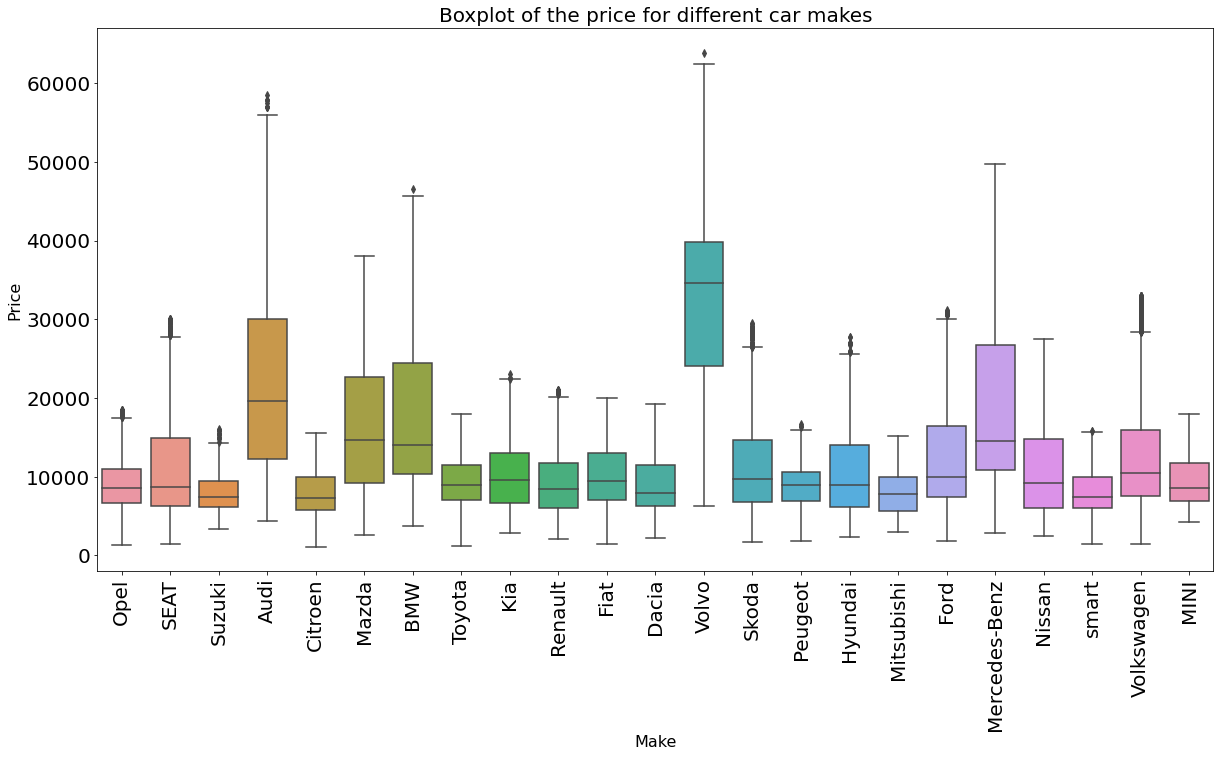

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x = cars.make, y = cars.price)

plt.xlabel('Make', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Boxplot of the price for different car makes', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

# Rotate the tick labels on the x-axis by 90 degrees
plt.xticks(rotation=90)

plt.show()

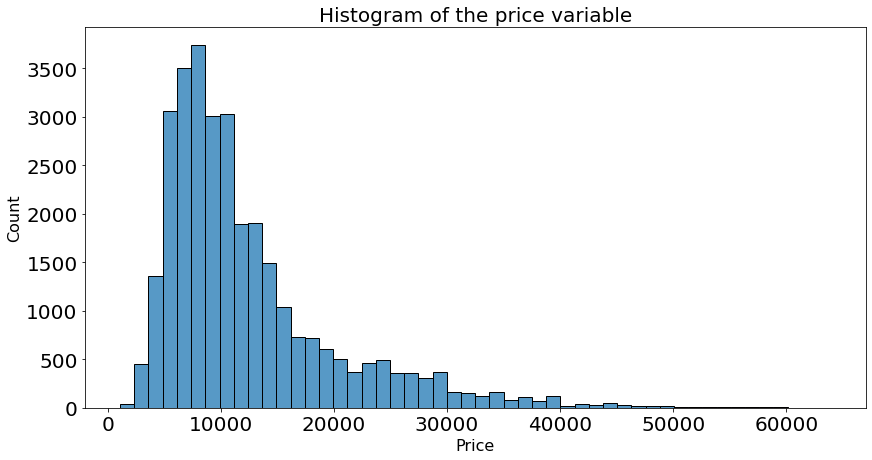

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(cars.price, bins = 50)
plt.xlabel('Price', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Histogram of the price variable', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

### 2.3.2 The horsepower variable

In [ ]:
cars.hp.describe()

count    31036.000000
mean       114.401083
std         44.879665
min          1.000000
25%         75.000000
50%        105.000000
75%        140.000000
max        450.000000
Name: hp, dtype: float64

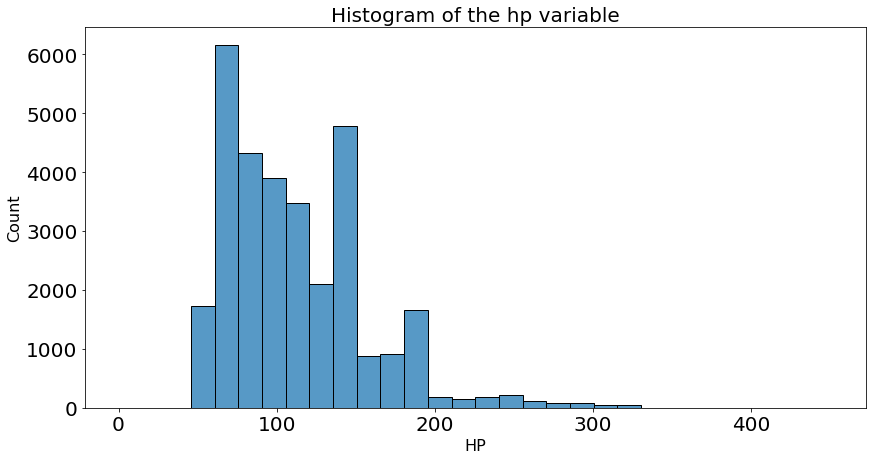

In [ ]:
plt.figure(figsize=(14,7))
sns.histplot(x=cars.hp, bins = 30)
plt.xlabel('HP', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Histogram of the hp variable', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

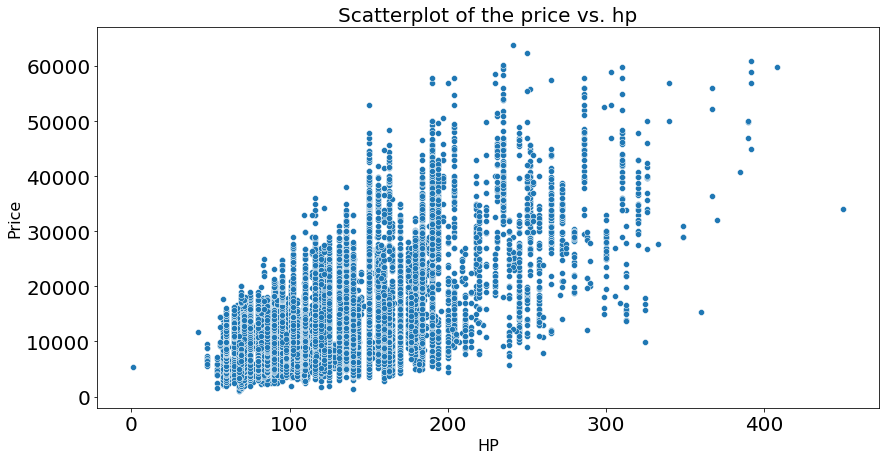

In [ ]:
plt.figure(figsize=(14,7))
sns.scatterplot(x = cars.hp, y = cars.price)

plt.xlabel('HP', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Scatterplot of the price vs. hp', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

It looks like the price increases with the horsepower of the car engine. We note the presence of a few datapoints having a large price (> 400,000) which look like outliers.

Next, let's plot a scatterplot of the price vs. mileage variables:

### 2.3.3 The mileage variable

In [ ]:
cars.mileage.describe()

count     31036
unique    15324
top          10
freq        564
Name: mileage, dtype: int64

We notice that the mileage is encoded as an integer. Let's convert it to a float.

In [ ]:
cars.mileage = cars.mileage.astype(float)
cars.mileage.describe()

count     31036.000000
mean      74840.360452
std       60241.104939
min           0.000000
25%       26664.000000
50%       65000.000000
75%      107972.250000
max      620000.000000
Name: mileage, dtype: float64

Let's draw a scatterplot of the price vs. mileage.

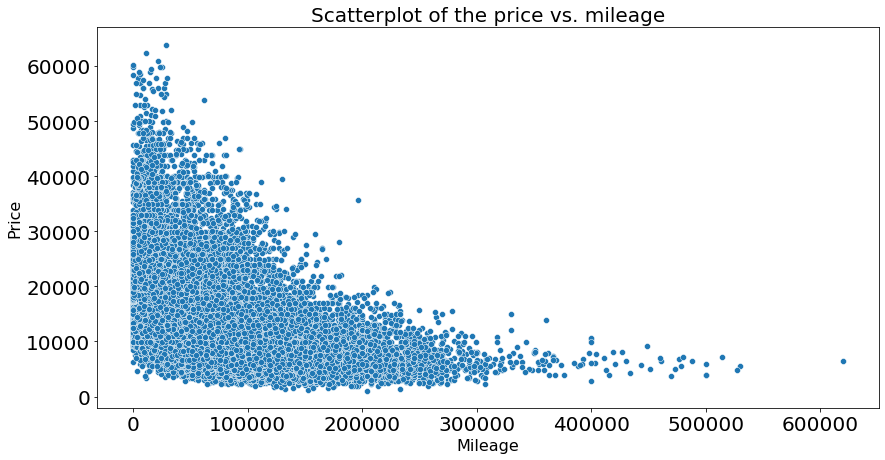

In [ ]:
plt.figure(figsize=(14,7))
sns.scatterplot(x = cars.mileage, y = cars.price)

plt.xlabel('Mileage', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Scatterplot of the price vs. mileage', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

The price seems to decrease with mileage as a general trend. This trend is more pronounced at higher values of the mileage variable.

### 2.3.4 The age variable

In [ ]:
cars.age = cars.age.astype(float)
cars.age.describe()

count    31036.000000
mean         6.283671
std          2.990520
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         11.000000
Name: age, dtype: float64

Let's draw a boxplot of the price for the 11 possible categories of the age variable.

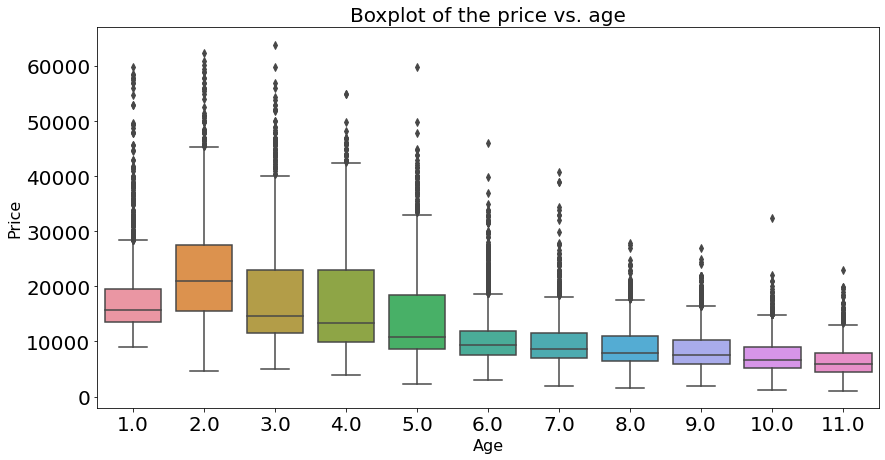

In [ ]:
plt.figure(figsize=(14,7))

sns.boxplot(x = cars.age, y = cars.price)

plt.xlabel('Age', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Boxplot of the price vs. age', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

It seems like the average price of cars decreases with the car age. We also note the presence of age specific outliers for every year in the age variable. Let us try to remove these.

In [ ]:
vehicles = pd.DataFrame(columns = cars.columns)
vehicles

,mileage,make,model,fuel,gear,offerType,price,hp,age,make_model


In [ ]:
for n in range(1,12):
    q75 = cars[cars.age == n].price.quantile(0.75)
    q25 = cars[cars.age == n].price.quantile(0.25)
    iqr = q75 - q25
    tmp_df = cars[(cars.age == n) & (cars.price < q75 + 1.5 * iqr) & (cars.price > q25 - 1.5 * iqr)]
    vehicles = pd.concat([vehicles, tmp_df], ignore_index=True)

vehicles.head()

,mileage,make,model,fuel,gear,offerType,price,hp,age,make_model
0,100.0,Opel,Corsa,Gasoline,Manual,Pre-registered,12990,75.0,1.0,OpelCorsa
1,15.0,Opel,Astra,Gasoline,Manual,Used,17900,131.0,1.0,OpelAstra
2,20.0,Opel,Corsa,Gasoline,Manual,Pre-registered,14190,75.0,1.0,OpelCorsa
3,10.0,Opel,Corsa,Gasoline,Manual,Pre-registered,11877,75.0,1.0,OpelCorsa
4,20.0,Opel,Corsa,Gasoline,Manual,Pre-registered,14390,75.0,1.0,OpelCorsa


In [ ]:
# Rename the vehicles dataframe as cars
cars = vehicles

Let's now draw a boxplot of the price for the different age categories and see if the outliers we found previously are still all there.

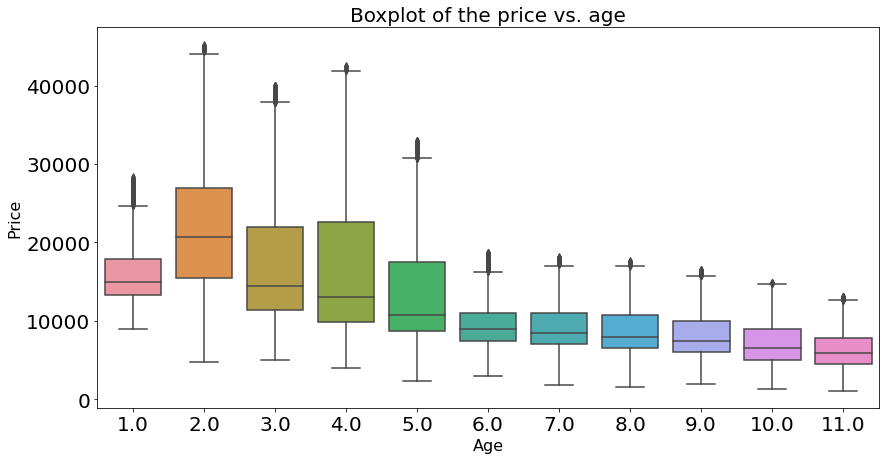

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(x = cars.age, y = cars.price)

plt.xlabel('Age', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Boxplot of the price vs. age', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

### 2.3.5 Correlations between the numerical variables

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29980 entries, 0 to 29979
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mileage     29980 non-null  float64
 1   make        29980 non-null  object 
 2   model       29980 non-null  object 
 3   fuel        29980 non-null  object 
 4   gear        29980 non-null  object 
 5   offerType   29980 non-null  object 
 6   price       29980 non-null  object 
 7   hp          29980 non-null  float64
 8   age         29980 non-null  float64
 9   make_model  29980 non-null  object 
dtypes: float64(3), object(7)
memory usage: 2.3+ MB


In [ ]:
cars.price = cars.price.astype(float)
cars.price.describe()

count    29980.000000
mean     11801.775284
std       7032.181943
min       1100.000000
25%       6990.000000
50%       9837.000000
75%      13980.000000
max      45250.000000
Name: price, dtype: float64

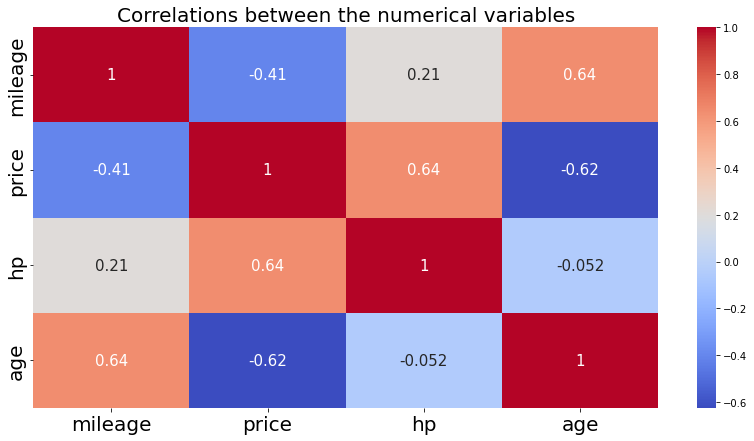

In [ ]:
plt.figure(figsize=(14,7))

sns.heatmap(cars.corr(),annot=True, cmap='coolwarm',annot_kws={'size': 15})

plt.title('Correlations between the numerical variables', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

It looks like the price variable has a moderate negative correlation with the mileage variable, and a slightly stronger correlation with the age and  horsepower ('hp') variables. We shall therefore keep all three features ('age', 'hp' and 'mileage') in our analysis.

For now, we'll move on to have a look at the categorical variables in our dataset.

## 2.4 Categorical variables
### 2.4.1 The fuel variable

Let's start by drawing a count plot of the fuel variable for the different categories of fuel in our dataset.

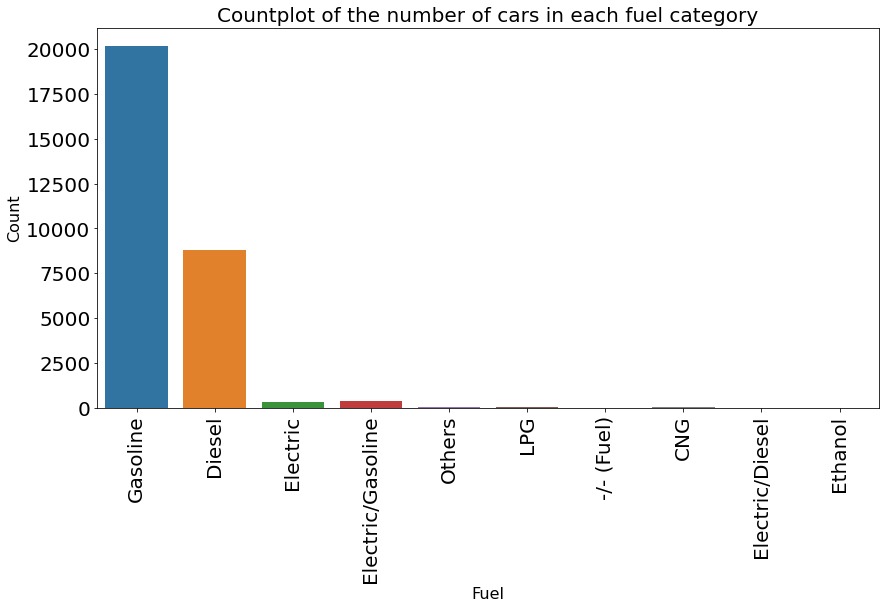

In [ ]:
plt.figure(figsize=(14,7))

sns.countplot(x=cars.fuel)

plt.xlabel('Fuel', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Countplot of the number of cars in each fuel category', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(rotation=90)
plt.show()

We note that there are two major categories of car fuel in our dataset: gasoline and diesel. The other categories are under-represented, and their presence in the dataset may affect the accuracy of our results. Let us make a boxplot of the price for each category.

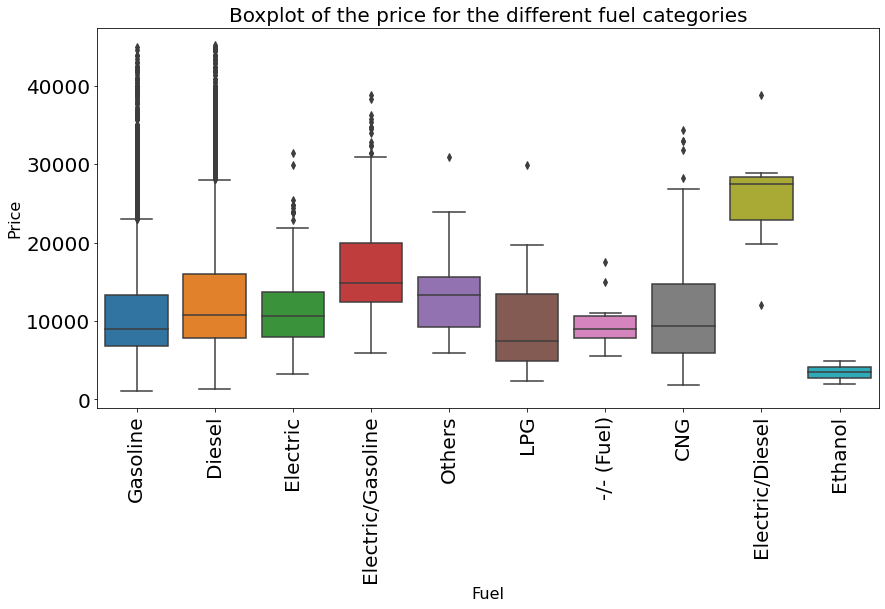

In [ ]:
plt.figure(figsize=(14,7))

sns.boxplot(x = cars.fuel, y = cars.price)

plt.xlabel('Fuel', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Boxplot of the price for the different fuel categories', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(rotation=90)
plt.show()

As there isn't a huge variation of the price between the different fuel types, we shall keep all these categories for the time being.

### 2.4.2 The gear variable

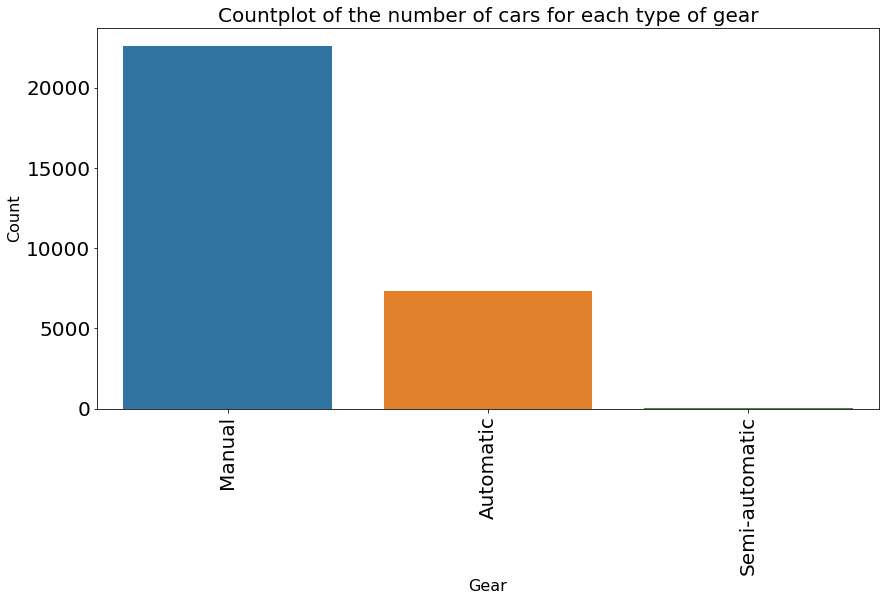

In [ ]:
plt.figure(figsize=(14,7))

sns.countplot(x=cars.gear)

plt.xlabel('Gear', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Countplot of the number of cars for each type of gear', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(rotation=90)
plt.show()

We note that the data is strongly imbalanced with the majority of cars in the dataset having a manual shift, and only about a third having an automatic gear (semi-automatic is even smaller).This again may lead to a loss of performance of our predictive model.

Let's now draw a barplot of the average price for each manufacturer showing the different gear categories.

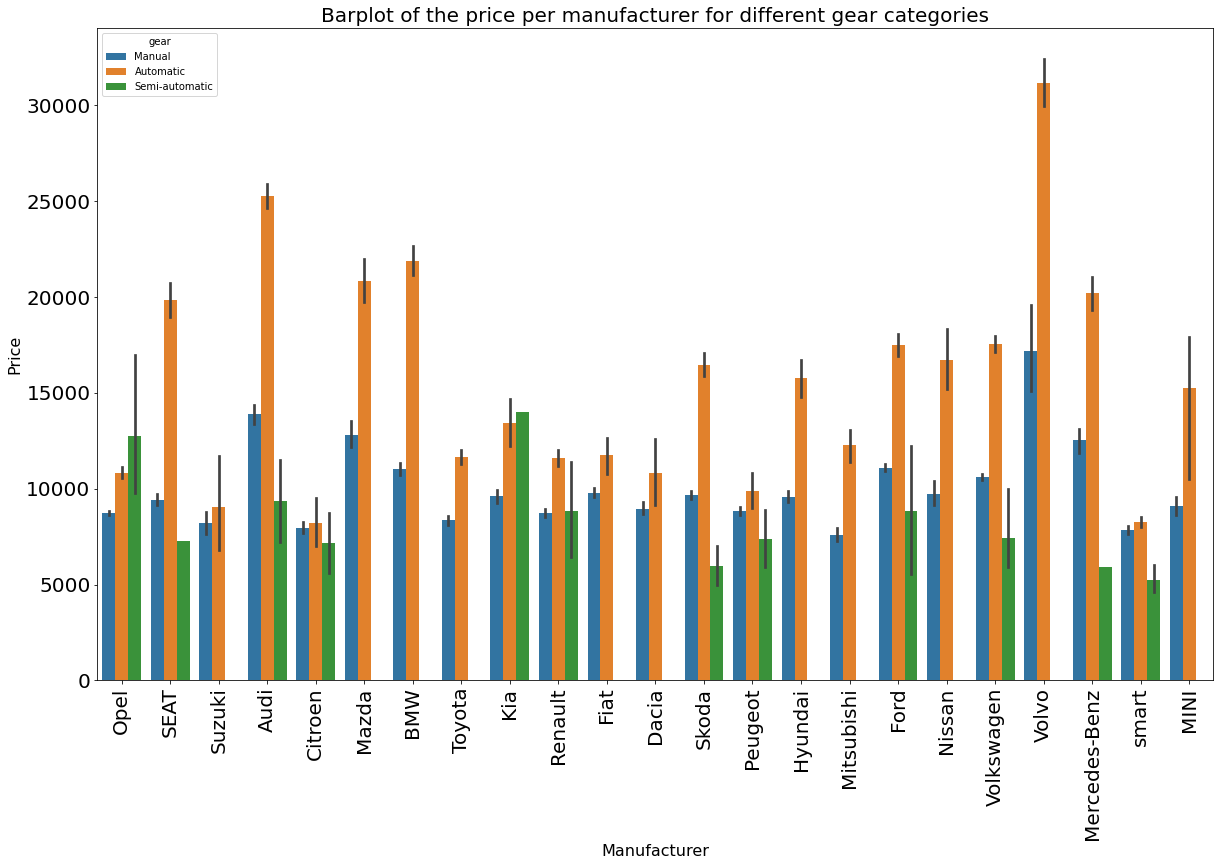

In [ ]:
plt.figure(figsize=(20,12))

sns.barplot(x = cars.make, y = cars.price, hue=cars.gear)

plt.xlabel('Manufacturer', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Barplot of the price per manufacturer for different gear categories', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(rotation=90)
plt.show()

Cars with automatic gear box seem to be a little more expensive that their manual or semi-automatic counterparts for all car makes.

### 2.4.3 The make categorical variable

In [ ]:
# Print the number of unique car manufacturers in our cars dataset
print('There are ', cars['make'].nunique() , ' unique car makers in the dataset.\n')

print('Here are the manufacturers according to how many rows of data they have in the dataset: ')
cars['make'].value_counts()

There are  23  unique car makers in the dataset.

Here are the manufacturers according to how many rows of data they have in the dataset: 


Volkswagen       5387
Opel             3855
Ford             3586
Skoda            2218
Renault          2136
Audi             1596
SEAT             1458
BMW              1222
Hyundai          1186
Fiat              908
smart             896
Mercedes-Benz     844
Toyota            829
Peugeot           707
Dacia             568
Kia               546
Mazda             489
Citroen           422
Nissan            367
Volvo             269
Mitsubishi        221
MINI              145
Suzuki            125
Name: make, dtype: int64

In [ ]:
# Let's find the average price by manufacturer: mean_price_per_manuf
mean_price_per_manuf = cars.groupby('make')[['price']].mean().sort_values(by='price')

# Display the first 5 rows of the resulting dataframe
mean_price_per_manuf.head()

,price
make,
Citroen,7983.431280
smart,8036.431920
Mitsubishi,8099.787330
Suzuki,8248.552000
Peugeot,8903.314003


In [ ]:
# Let's find the average price of a few car makes
print('Mean price of a used Audi: ', mean_price_per_manuf.loc['Audi'])
print('Mean price of a used Mercedes-Benz: ', mean_price_per_manuf.loc['Mercedes-Benz'])
print('Mean price of a Nissan: ', mean_price_per_manuf.loc['Nissan'])
print('Mean price of a Toyota: ', mean_price_per_manuf.loc['Toyota'])

Mean price of a used Audi:  price    20235.783208
Name: Audi, dtype: float64
Mean price of a used Mercedes-Benz:  price    17026.020142
Name: Mercedes-Benz, dtype: float64
Mean price of a Nissan:  price    10976.275204
Name: Nissan, dtype: float64
Mean price of a Toyota:  price    9264.288299
Name: Toyota, dtype: float64


In [ ]:
# Reset the index so that the car make has its own column
mean_price_per_manuf.reset_index(inplace=True)

# Rename the columns
mean_price_per_manuf.rename(columns={'make':'make', 'price':'avg_price'}, inplace=True)

# Inspect the result
mean_price_per_manuf.head()

,make,avg_price
0,Citroen,7983.431280
1,smart,8036.431920
2,Mitsubishi,8099.787330
3,Suzuki,8248.552000
4,Peugeot,8903.314003


Let's use the data we generated above to make a barplot of the average price per car manufacturer.

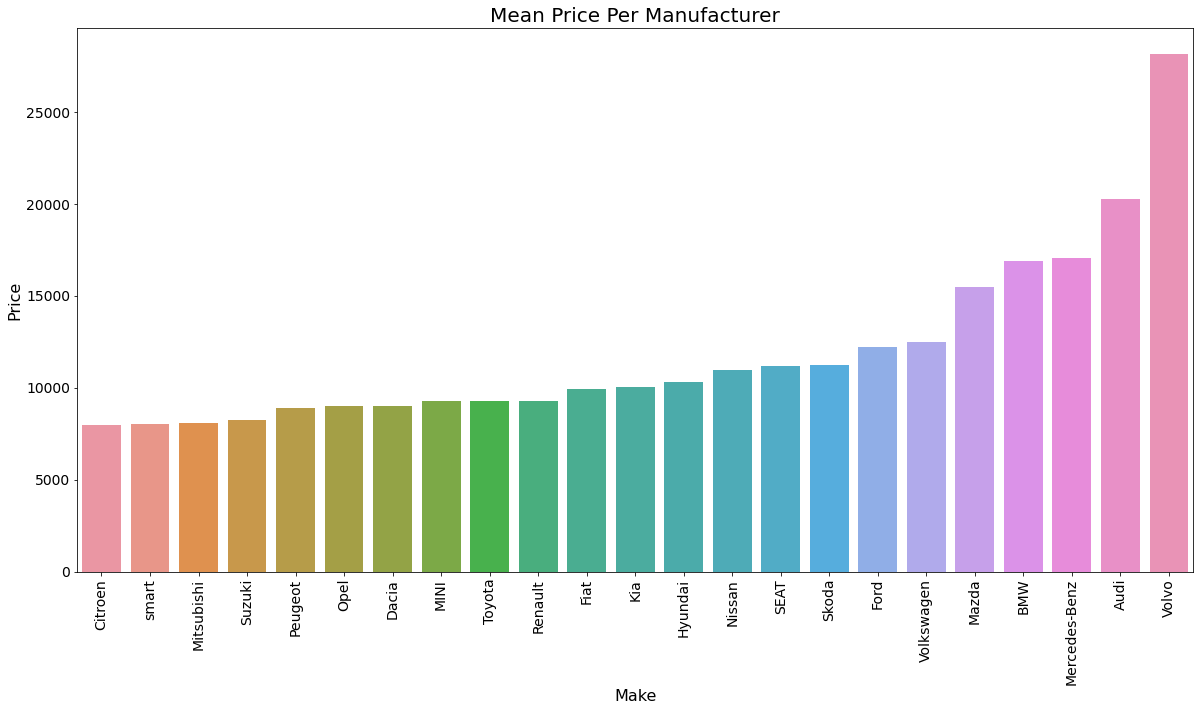

In [ ]:
# Set the figure size
plt.figure(figsize=(20,10))

# Draw a barplot using seaborn
sns.barplot(data=mean_price_per_manuf, x=mean_price_per_manuf['make'], y = mean_price_per_manuf['avg_price'])

# Note that we could have achieved the same result using pandas:
#mean_price_per_manuf.plot(kind = 'bar')

# Rotate the tick labels on the x-axis by 90 degrees
plt.xticks(rotation=90)

# Set the labels fonts and font sizes
plt.xlabel('Make', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.title('Mean Price Per Manufacturer', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

We can see that there is quite a disparity in the average price of a car depending on its make: the average price of a used Audi for example (at about 21K) is much higher than the average price of a used Nissan (9700) or a used Toyota (9300). It therefore doesn't make a lot of sense to try to predict the price of a car from a certain manufacturer by looking at car prices from all manufacturers. Actually, below we will see that the price does vary even between different models from the same manufacturer, so ideally we will want to use data for the same make and model to predict the price of any given make and model.